## Installing the required packages
```bash
pip install -r requirements.txt
```

In [7]:
import pm4py
import os
import json
from dotenv import load_dotenv
load_dotenv()

True

## Conversation logs to Event logs
The ``event-reader`` library is used to generate event logs from the conversation logs of a database. The library can be installed using the following command:

```bash
pip install event-reader
```

In [3]:
from event_reader import get_db_connection, generate_eventlog

mysql_user = os.getenv('MYSQL_USER', 'root')
mysql_password = os.getenv('MYSQL_PASSWORD', 'root')
mysql_host = os.getenv('MYSQL_HOST', 'localhost')
mysql_db = os.getenv('MYSQL_DB', 'EVENTLOG')
mysql_port = os.getenv('MYSQL_PORT', 3306)

# replace this with the identifier of your bot
resource_id = '2823648950cad1beb11b6cbdb0101b2a6e868593ea616ab1368cbb96bd4b787a88c120d754342c90f3d872f9740288e5b28b9b02e9237c3d1bdfa270d290208b'

db_connection = get_db_connection(
    mysql_host, mysql_port, mysql_user, mysql_password, mysql_db)
event_log = df = generate_eventlog(
    db_connection, resource_ids=[resource_id])
event_log.head()

Reading events from database from None until None


,EVENT_TYPE,REMARKS,RESOURCE,RESOURCE_TYPE,case:concept:name,concept:name,in-service-context,intent,lifecycle:transition,serviceEndpoint,stateLabel,time:timestamp,user
0,USER_MESSAGE,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",2823648950cad1beb11b6cbdb0101b2a6e868593ea616a...,bot,1efd9cfd-6128-4da4-b8cd-b13a8cabd0c5,greeting,False,greeting,complete,,greeting,2023-11-01 16:32:09,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...
1,USER_MESSAGE,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",2823648950cad1beb11b6cbdb0101b2a6e868593ea616a...,bot,7dab93e6-5237-4d83-9a11-552059b796ad,menu,False,menu,complete,,requestMenu,2023-11-01 16:32:34,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...
3,SERVICE_REQUEST,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",2823648950cad1beb11b6cbdb0101b2a6e868593ea616a...,bot,7dab93e6-5237-4d83-9a11-552059b796ad,getMenu,False,NaN,complete,https://mobsos.tech4comp.dbis.rwth-aachen.de/m...,NaN,2023-11-01 16:32:37,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...
4,USER_MESSAGE,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",2823648950cad1beb11b6cbdb0101b2a6e868593ea616a...,bot,7dab93e6-5237-4d83-9a11-552059b796ad,menu,True,number_selection,complete,,requestMenu,2023-11-01 16:32:44,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...
6,SERVICE_REQUEST,"{""user"": ""155afb0b06460d7c3bb33b23f91f71e1cc86...",2823648950cad1beb11b6cbdb0101b2a6e868593ea616a...,bot,7dab93e6-5237-4d83-9a11-552059b796ad,getMenu,False,NaN,complete,https://mobsos.tech4comp.dbis.rwth-aachen.de/m...,NaN,2023-11-01 16:32:45,155afb0b06460d7c3bb33b23f91f71e1cc865bbe043051...


## Model Discovery
Using the event_log, we can discover the process model using the ``pm4py`` library. Alternatively, we can also use the helper functions from the discovery module.

In [ ]:
from discovery.main import discover_petri_net

event_log = pm4py.read_xes( "./assets/event_logs/demo.xes")
net, initial_marking, final_marking = discover_petri_net(event_log, algorithm='inductive')
pm4py.view_petri_net(net, initial_marking, final_marking)

`bot_statistics` returns the conversation statistics of the chatbot. The statistics include the number of conversations, the number of unique states, the number of individual users, the average conversation length and average conversation duration.

In [6]:
from discovery.main import bot_statistics, discover_petri_net

bot_statistics(event_log)

{'numberOfConversations': 22,
 'numberOfStates': 14,
 'numberOfUsers': 1,
 'averageConversationLength': 9.0,
 'averageConversationDuration': 11.863636}

## Bot Model Transformation
This library also allows us to transform the bot model into a process model. The bot model can be transformed into a process model using the ``bot_to_process_model`` function. The function takes the bot model and transforms it into a process model.

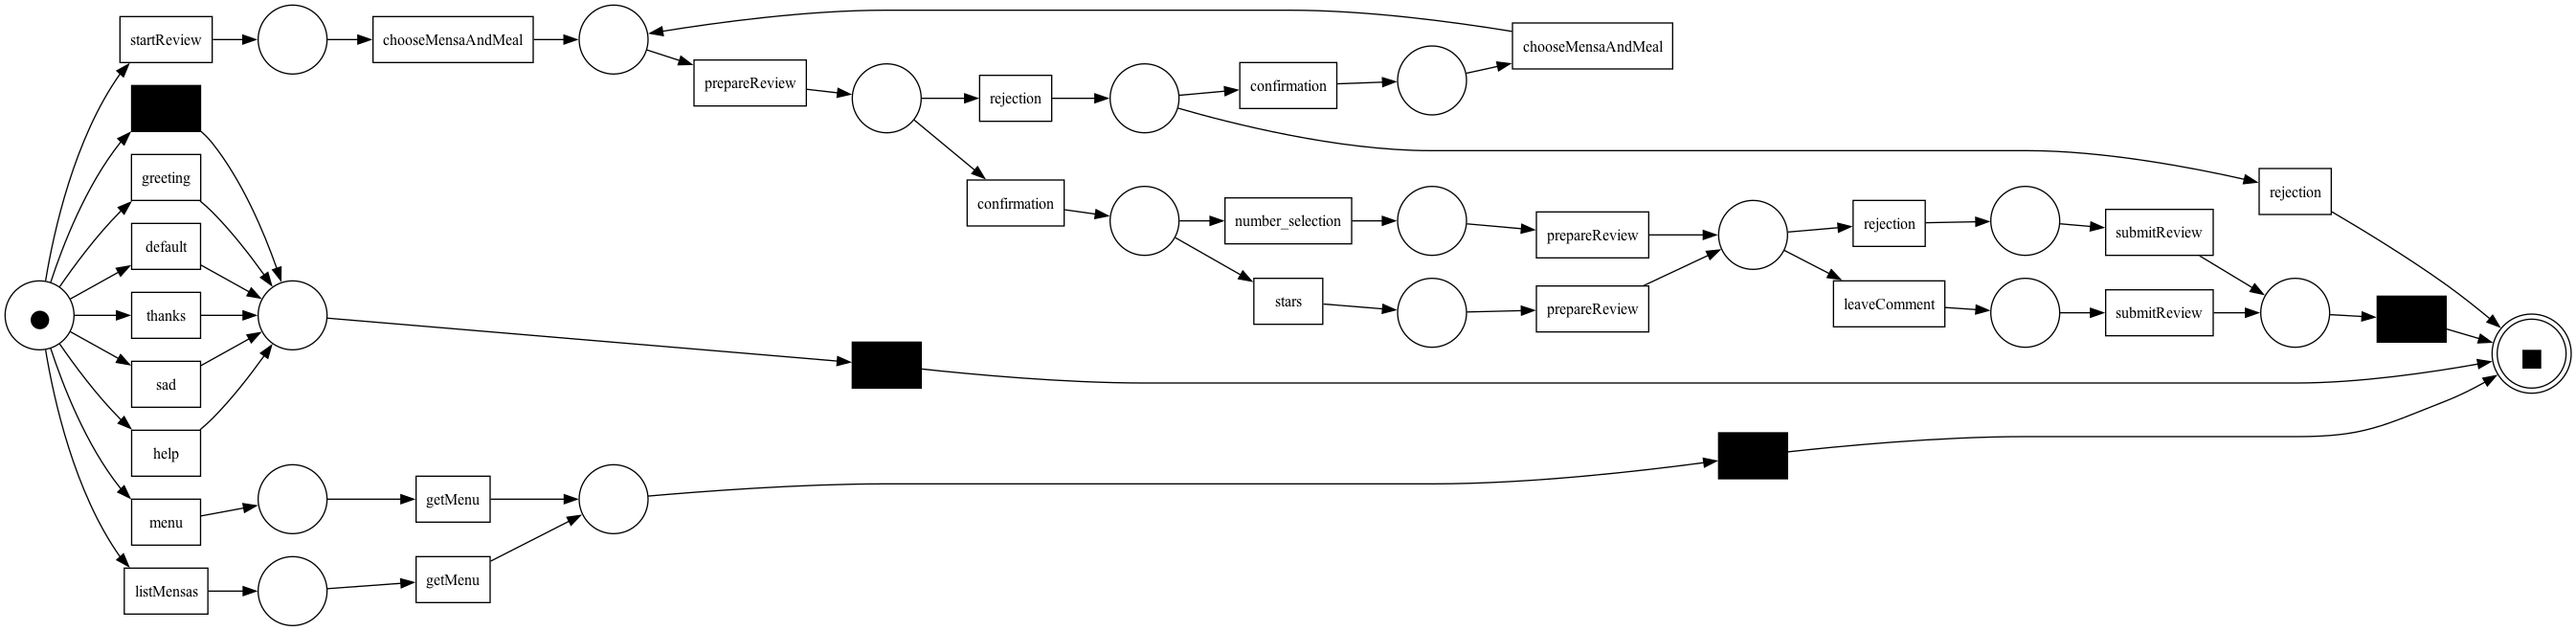

In [9]:
from utils.bot.parse_lib import get_parser

bot_model = json.loads(
    open("./assets/models/mensabot.json").read())
parser = get_parser(bot_model)
net, initial_marking, final_marking = parser.to_petri_net()
pm4py.view_petri_net(net, initial_marking, final_marking)

## Conformance Checking
The ``conformance`` module allows us to check the conformance of the bot model with the event log. 
`conformance` gives the precision and fitness of the bot model with respect to the event log. 

In [10]:
from conformance.main import conformance

conformance(event_log, net, initial_marking, final_marking)

aligning log, completed variants :: 100%|██████████| 12/12 [00:00<00:00, 57.44it/s]
computing precision with alignments, completed variants :: 100%|██████████| 91/91 [00:00<00:00, 597.85it/s]


{'fitness': {'percFitTraces': 0.0,
  'averageFitness': 0.20684113865932047,
  'percentage_of_fitting_traces': 0.0,
  'average_trace_fitness': 0.20684113865932047,
  'log_fitness': 0.2424274410063615},
 'precision': 0.3721804511278195}

`find_unfitting_traces` returns the traces that are not fitting the bot model.

In [12]:
from conformance.main import find_unfitting_traces
# example of the first unfitting trace
find_unfitting_traces(event_log, net, initial_marking, final_marking)[0]

aligning log, completed variants :: 100%|██████████| 12/12 [00:00<00:00, 47.87it/s]


{'alignment': [('startReview', '>>'),
  ('startReview', '>>'),
  ('startReview:response', '>>'),
  ('startReview:response', '>>'),
  ('quit', '>>'),
  ('quit', '>>'),
  ('startReview', '>>'),
  ('startReview', '>>'),
  ('default:response', '>>'),
  ('default:response', '>>'),
  ('>>', None),
  ('>>', None)],
 'cost': 100002,
 'visited_states': 12,
 'queued_states': 114,
 'traversed_arcs': 114,
 'lp_solved': 1,
 'fitness': 0.0,
 'bwc': 100002}

## Model Enhancement
The ``enhancement`` module allows us to enhance the bot model using the event log. 
`enhance_bot_model` returns the enhanced bot model using the event log. This includes a frequency and performance enhanced conversation model.
It optionally also allows us to repair the bot model using the event log.

aligning log, completed variants :: 100%|██████████| 12/12 [00:00<00:00, 46.03it/s]


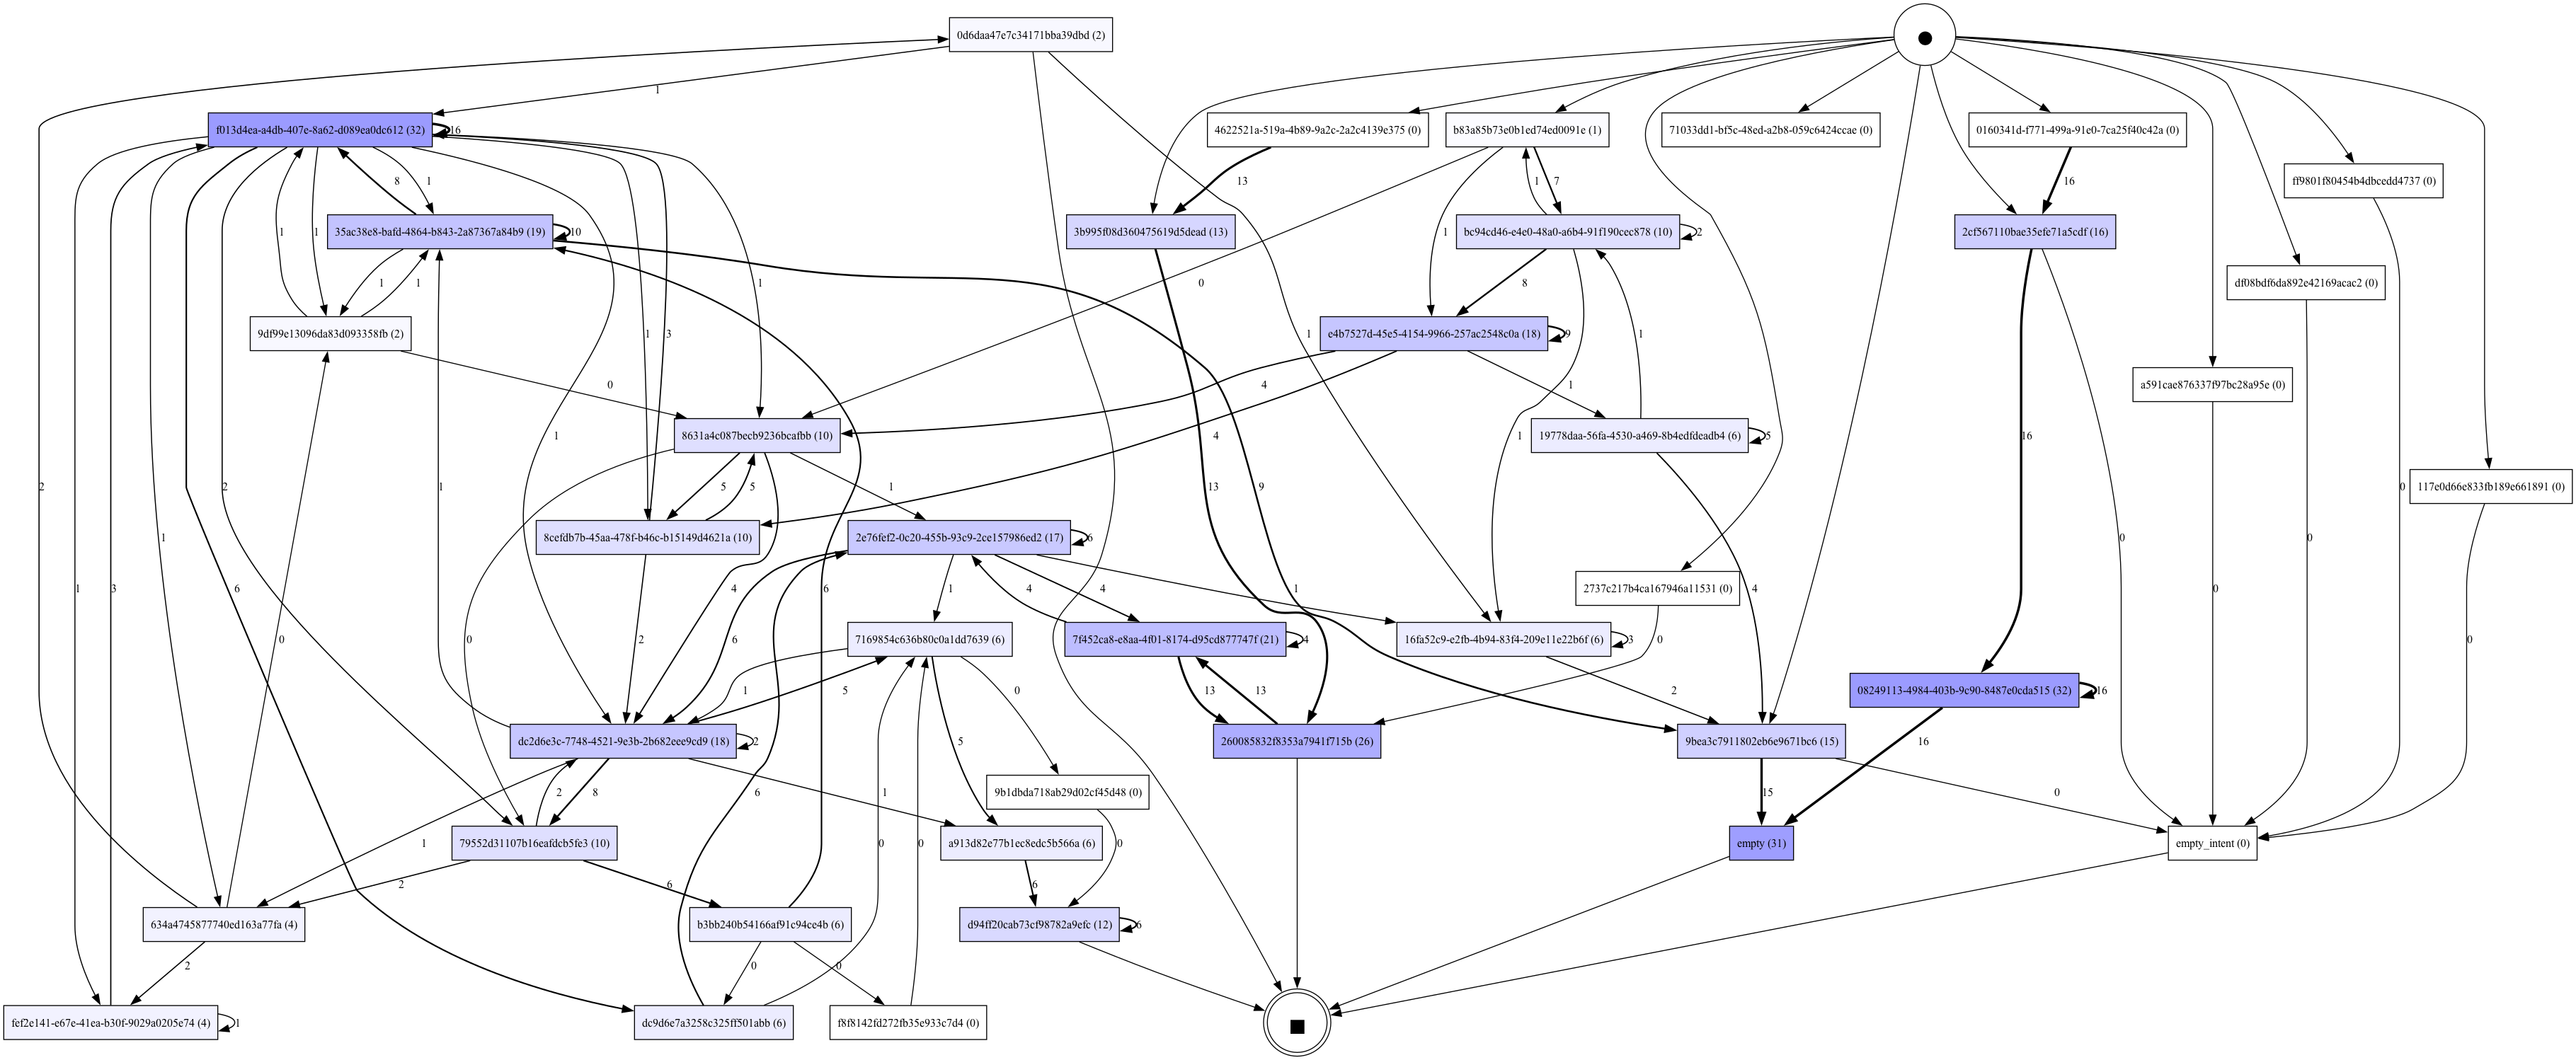

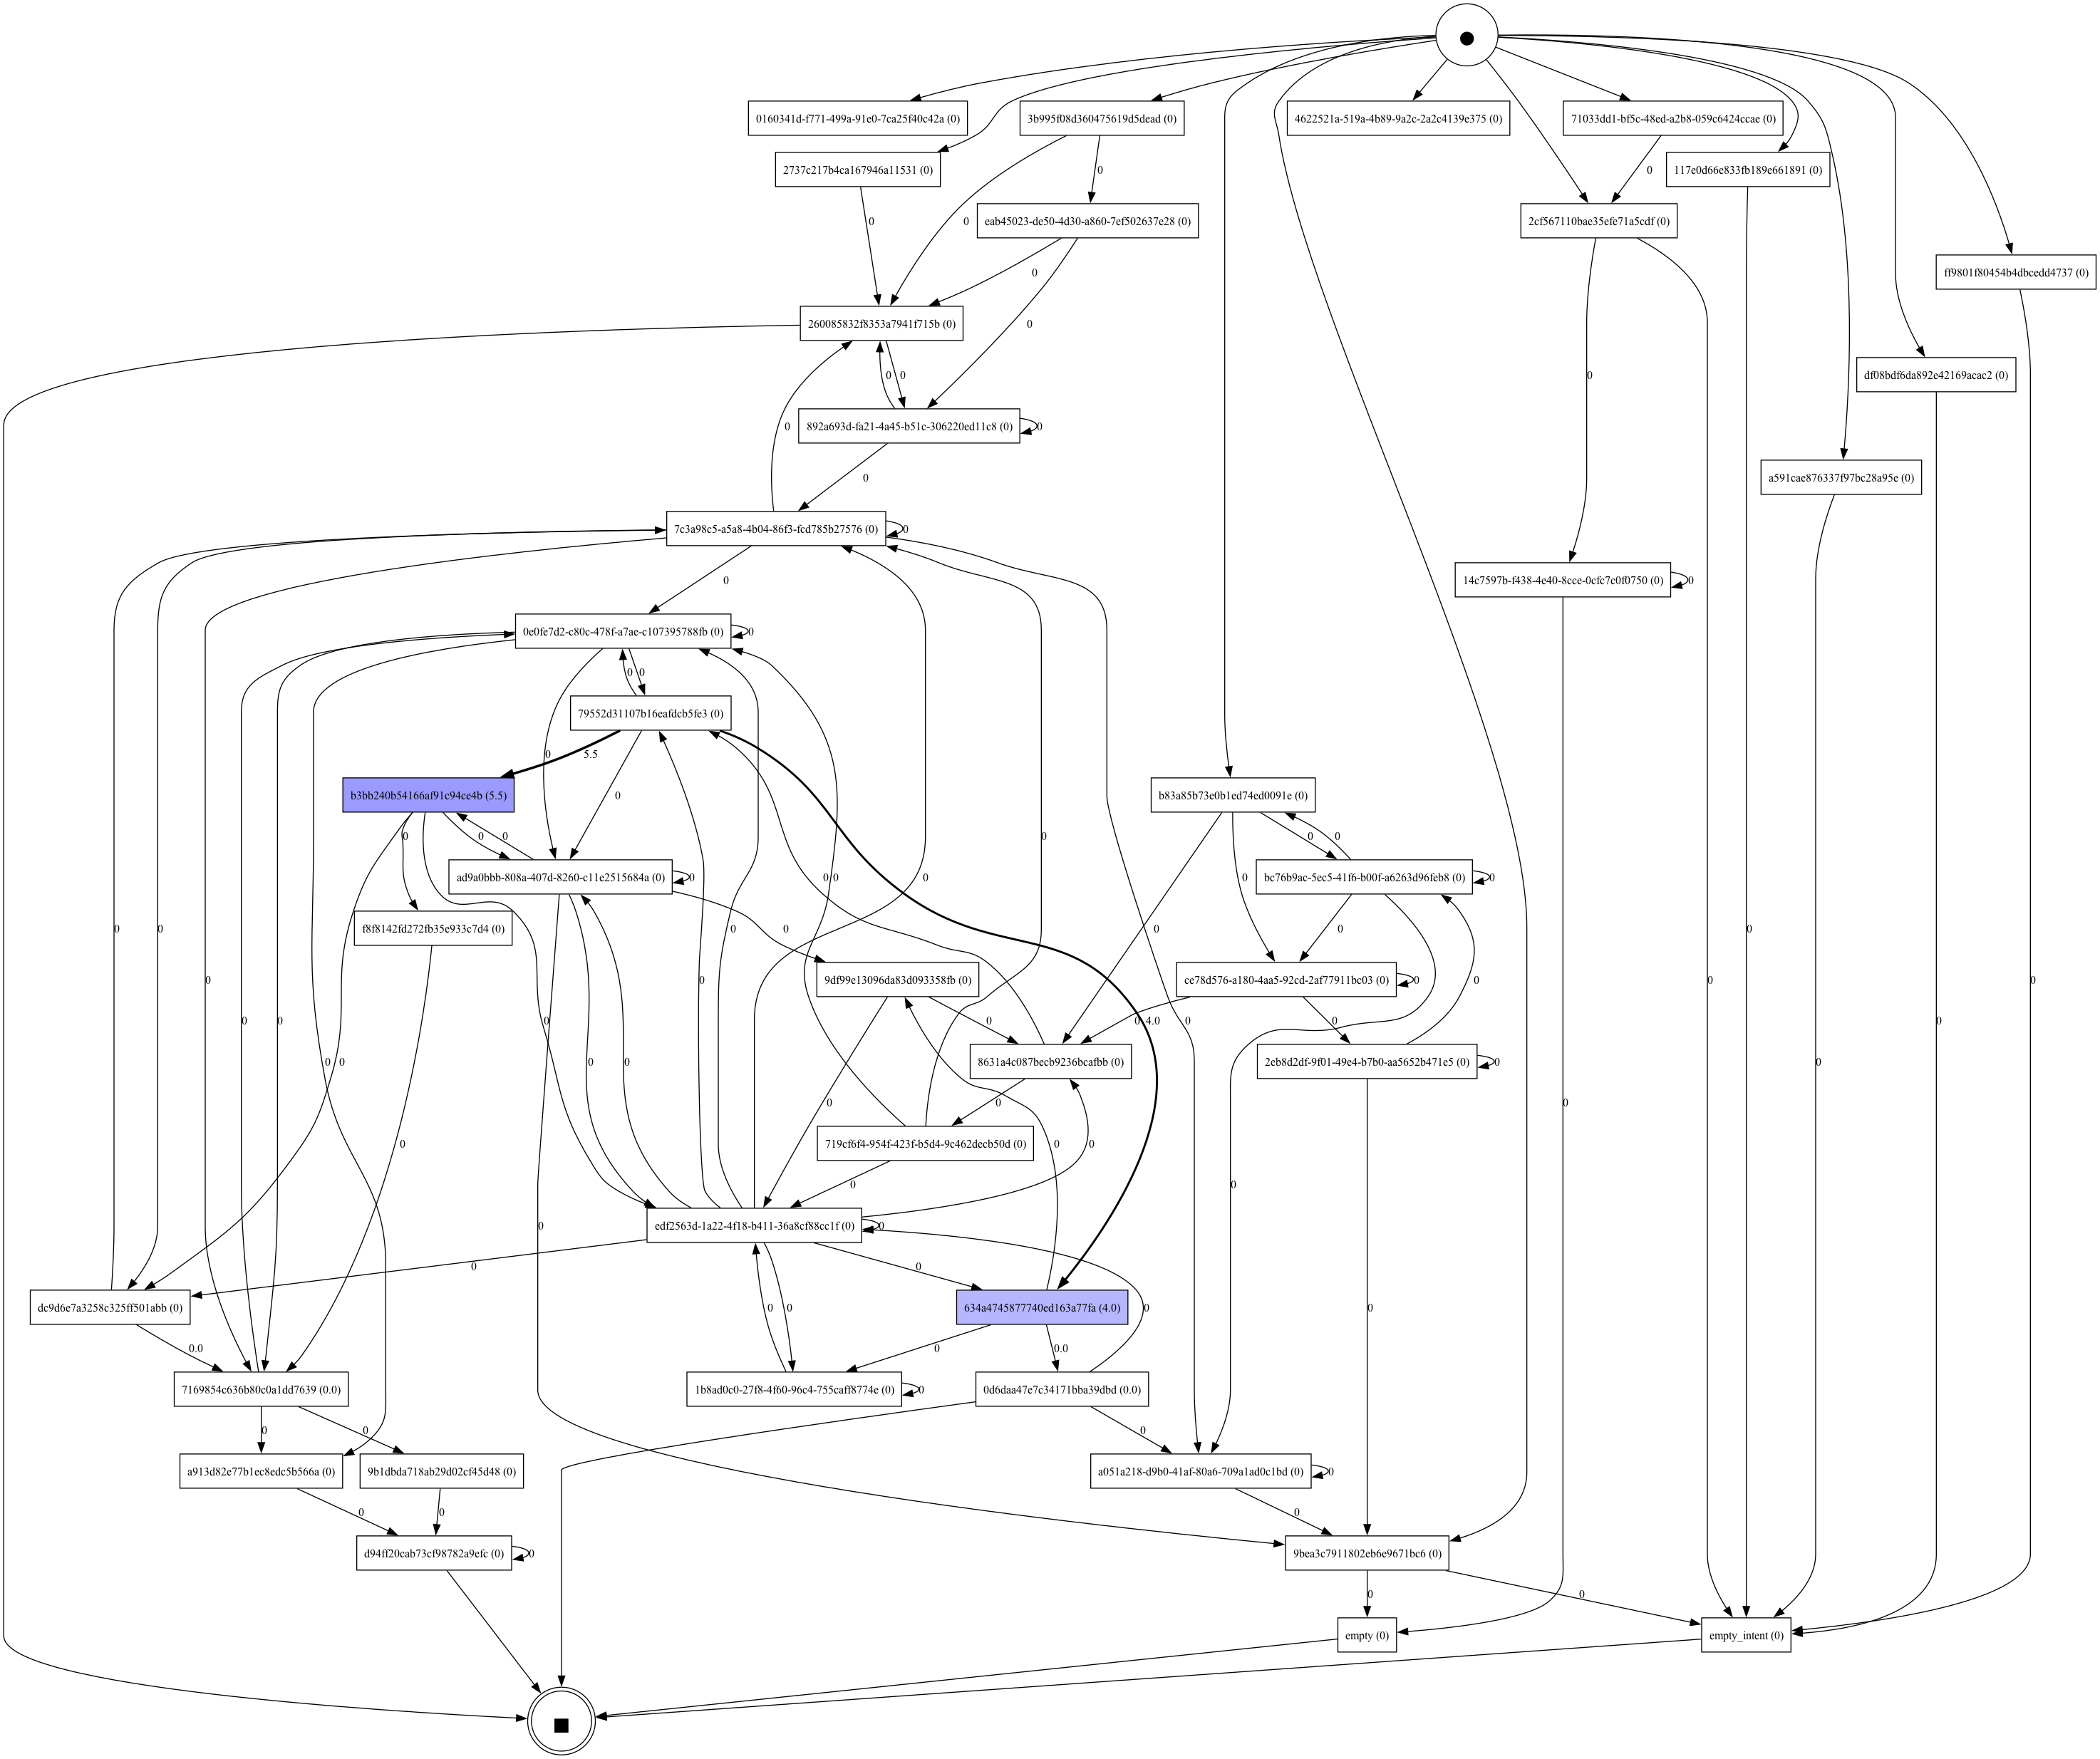

In [14]:
from enhancement.main import enhance_bot_model

_, start_activities, end_activities, frequency_dfg, performance_dfg = enhance_bot_model(
    event_log, bot_parser=parser, repair=True)

pm4py.view_dfg(frequency_dfg, start_activities, end_activities)
pm4py.view_dfg(performance_dfg, start_activities, end_activities)
